In [1]:
import numpy as np  

In [83]:
from scipy.optimize import curve_fit
from scipy.constants import N_A

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm

In [4]:
import itertools

In [5]:
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.)
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})

In [6]:
import mdtraj as md

# Dense phases

In [19]:
system = "argon"

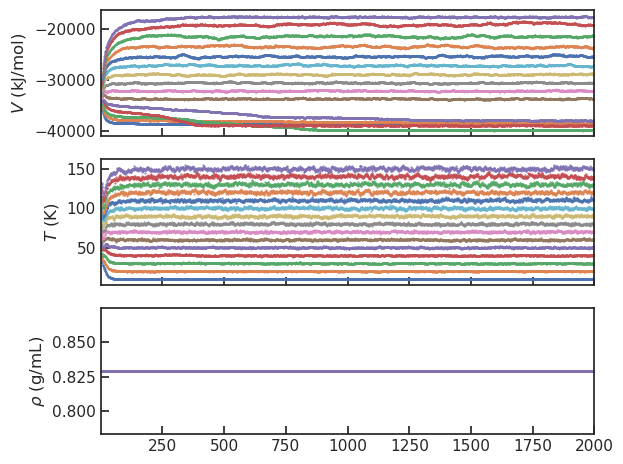

In [20]:
fig, ax = plt.subplots(3,1, sharex=True, sharey=False)
for t in range(10,160,10):
    data = np.loadtxt("data/%s_slab_T%g_equil.csv"%(system,t), delimiter=',')
    ax[0].plot(data[:,0], data[:,1], '.', ms=1)
    #ax[0].set_ylim(-30000,200)
    ax[1].plot(data[:,0], data[:,2], '.', ms=1)
    ax[2].plot(data[:,0], data[:,3], '.', ms=1)
ax[0].set_ylabel(r'$V$ (kJ/mol)')
#ax[1].set_ylim(250,350)
ax[1].set_ylabel(r'$T$ (K)')
ax[2].set_ylabel(r'$\rho$ (g/mL)')
ax[2].set_xlim(data[0,0], data[-1,0])
plt.tight_layout()

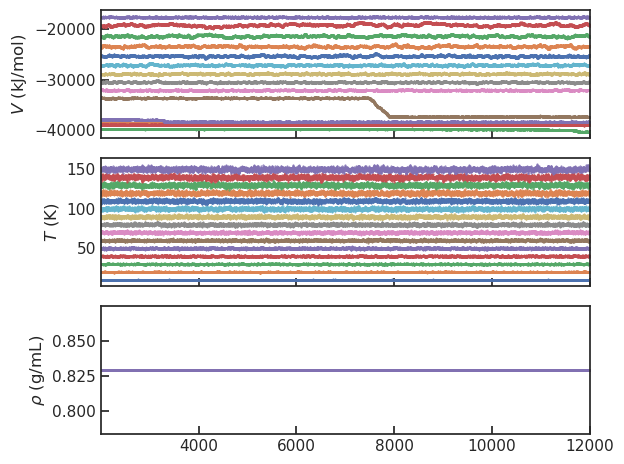

In [21]:
fig, ax = plt.subplots(3,1, sharex=True, sharey=False)
for t in range(10,160,10):
    data = np.loadtxt("data/%s_slab_T%g_prod.csv"%(system,t), delimiter=',')
    ax[0].plot(data[:,0], data[:,1], '.', ms=1)
    #ax[0].set_ylim(-30000,200)
    ax[1].plot(data[:,0], data[:,2], '.', ms=1)
    ax[2].plot(data[:,0], data[:,3], '.', ms=1)
ax[0].set_ylabel(r'$V$ (kJ/mol)')
#ax[1].set_ylim(250,350)
ax[1].set_ylabel(r'$T$ (K)')
ax[2].set_ylabel(r'$\rho$ (g/mL)')
ax[2].set_xlim(data[0,0], data[-1,0])
plt.tight_layout()

/tmp/ipykernel_354635/1053035411.py:7: RuntimeWarning: divide by zero encountered in log
  ax[1].plot(bins, -np.log(g_r))


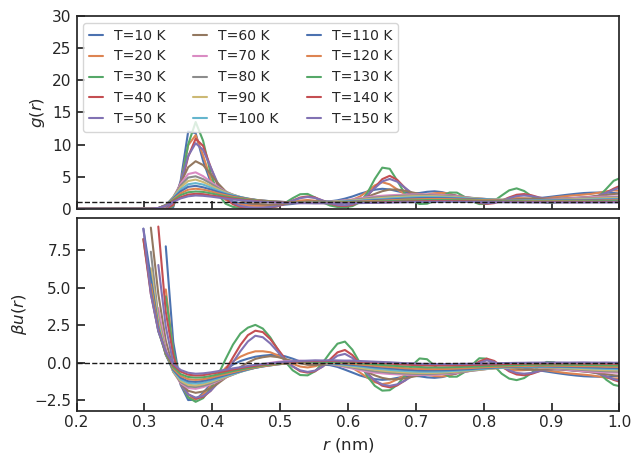

In [22]:
fig, ax = plt.subplots(2,1, sharex=True)
for t in range(10,160,10):
    traj = md.load_dcd("data/%s_slab_T%g_prod.dcd"%(system,t), top="data/%s_slab_T%g_min.pdb"%(system,t), stride=20)
    bins, g_r = md.compute_rdf(traj, list(itertools.combinations(range(1000), 2)), \
                               r_range=[0.15,1.25], n_bins=100)
    ax[0].plot(bins, g_r, label='T=%g K'%t)
    ax[1].plot(bins, -np.log(g_r))

ax[0].axhline(1,0,1,ls='dashed', lw=1, color='k')
ax[1].axhline(0,0,1,ls='dashed', lw=1, color='k')
ax[0].set_xlim(0.2,1)
ax[0].set_ylim(0,30)
ax[1].set_xlabel('$r$ (nm)')
ax[0].set_ylabel(r'$g(r)$')
ax[1].set_ylabel(r'$\beta u(r)$')
ax[0].legend(loc=2, fontsize=10, handlelength=1, ncols=3)
plt.tight_layout(h_pad=0)

In [23]:
def tanh_function(x, p0, p1, p2, p3):
    return p0 + p1*(np.tanh(p2-x) + (1 - np.tanh(p3-x)) + 1)/2 

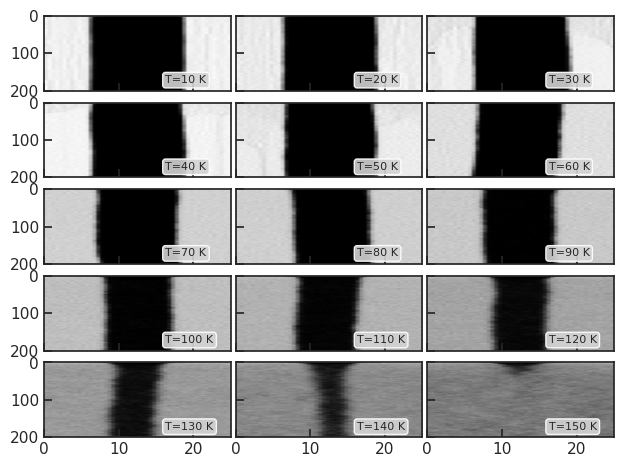

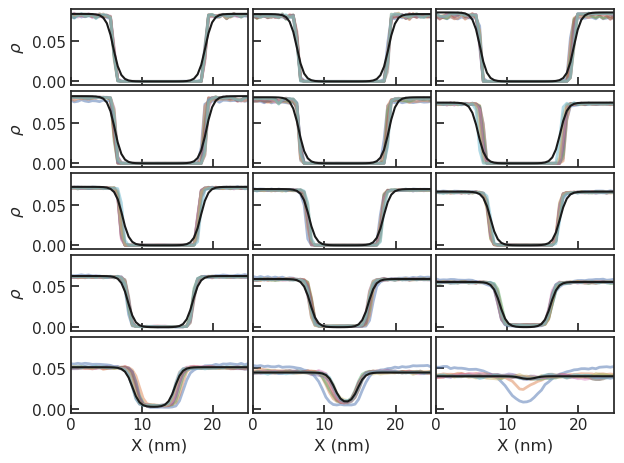

In [30]:
system = "argon" # ["neon", "argon", "krypton", "xenon"]:
temps = list(range(10, 160, 10))

fig, ax = plt.subplots(5,3, sharex=True, sharey=True)
fig2, ax2 = plt.subplots(5,3, sharex=True, sharey=True)

rho_vals = []
xvals = np.linspace(0,25,50)

ax = ax.flatten()
ax2 = ax2.flatten()
for i,t in enumerate(temps):
    traj = md.load_dcd("data/%s_slab_T%g_equil.dcd"%(system,t), top="data/%s_slab_T%g_min.pdb"%(system,t), stride=10)
    hists = np.array([np.histogram(traj.xyz[i,:,0], bins=np.linspace(0,25,51), \
                                   density=True)[0] for i in range(traj.n_frames)])
    ax[i].imshow(hists, extent=[0,25, 200, 0],  aspect=0.05, cmap='binary_r', origin='upper')
    ax[i].text(0.65,0.1,'T=%g K'%t, transform=ax[i].transAxes, fontsize=8, \
               bbox=dict(facecolor='lightgray', alpha=0.9, boxstyle='round', pad=0.25))
    
    [ax2[i].plot(xvals, np.mean(hists[k*20:(k+1)*20], axis=0), lw=2, alpha=0.5) for k in range(10)]
    popt, pcov = curve_fit(tanh_function, xvals, np.mean(hists[-20:], axis=0), bounds=[0., [0.3, 0.3, 25, 25]])
    #print ("rho_a=%.2e; rho_b=%.2e"%(popt[0], popt[1]+popt[0]))
    rho_vals.append([popt[0], popt[1]+popt[0]])
    ax2[i].plot(xvals, tanh_function(xvals, *popt), label='$p_{opt}$', color='k')

[ax2[-i-1].set_xlabel('X (nm)') for i in range(3)]
[ax2[i*3].set_ylabel(r'$\rho$') for i in range(4)]
ax2[0].set_xlim(0,25)
fig.tight_layout(w_pad=0, h_pad=0)
fig2.tight_layout(w_pad=0, h_pad=0)

In [ ]:
def critical_temp(x, Tc, A):
    """
    $ \rho_h - \rho_l = A*(T_c - T)^\beta $
    """
    return A*(Tc - x)**0.325

def rectilinear(x, rhoc, C):
    """
    $ (\rho_h + \rho_l)/2 = \rho_c + C*(T_c - T) $
    """
    return rhoc + C*x

In [ ]:
xvals = np.array(temps)[:-2]
yvals = np.array([x[1]-x[0] for x in rho_vals])[:-2]

popt, pcov = curve_fit(critical_temp, xvals, yvals, p0=[160,1])
print ("Tc=%g; A=%g"%(popt[0], popt[1]))
Tc = popt[0]
A = popt[1]

Tc=155.921; A=0.0170705


In [61]:
xvals = Tc - np.array(temps)[:-2]
yvals = np.array([0.5*(x[1]+x[0]) for x in rho_vals])[:-2]
popt, pcov = curve_fit(rectilinear, xvals, yvals, p0=[160,1])
print ("rhoc=%g; C=%g"%(popt[0], popt[1]))
rhoc = popt[0]
C = popt[1]

rhoc=0.0236967; C=0.000138699


In [74]:
tvals = np.linspace(0,Tc, 200)
rhoh = 0.5*(critical_temp(tvals, Tc, A) + 2*rectilinear(Tc - tvals, rhoc, C))
rhol = rhoh -  critical_temp(tvals, Tc, A)

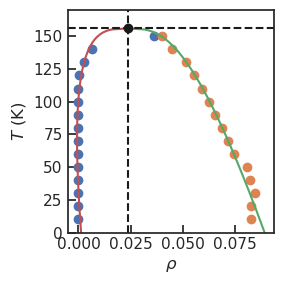

In [ ]:
plt.subplots(figsize=(3,3))
plt.plot([x[0] for x in rho_vals], temps, 'o')
plt.plot([x[1] for x in rho_vals], temps, 'o')

plt.plot(rhoh, tvals)
plt.plot(rhol, tvals)
plt.plot(rhoc, Tc, 'o', color='k')

plt.axhline(Tc, ls='--', color='k')
plt.axvline(rhoc, ls='--', color='k')
plt.xlabel(r'$\rho$')T
plt.ylabel('$T$ (K)')
plt.ylim(0,170)
plt.tight_layout()